# Notebook 03 - Drought in the Netherlands with Time Series Modeling

*Martin Vonk - 2022*

This notebooks shows a quick calculation of the SPI, SPEI and SGI for De Bilt, in the Netherlands. The SGI is calculated using a [Pastas](https://github.com/pastas/pastas) time series model since the original time series is too short. The application of time series models for extrapolating groundwater time series is discussed in [Brakkee et al (2022)](https://hess.copernicus.org/articles/26/551/2022/hess-26-551-2022.html).

## Required packages

In [1]:
import datetime

import hydropandas as hpd
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps
import scipy.stats as scs

import spei as si  # si for standardized index

print(si.show_versions())

/home/martin/repos/SPEI/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


python: 3.13.1
spei: 0.6.1
numpy: 2.2.4
scipy: 1.15.2
matplotlib: 3.10.1
pandas: 2.2.3


## Import time series

Time series are imported using the package hydropandas. Enddate is by default yesterday. The head time series is obtained from a Pastas test dataset.

In [2]:
today = datetime.date.today()
yesterday = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
prec = (
    hpd.PrecipitationObs.from_knmi(
        meteo_var="RH", stn=260, startdate="1959-07-01", enddate=yesterday
    )
    .multiply(1e3)
    .squeeze()
)
prec.index = prec.index.normalize()
evap = (
    hpd.EvaporationObs.from_knmi(
        meteo_var="EV24", stn=260, startdate="1959-07-01", enddate=yesterday
    )
    .multiply(1e3)
    .squeeze()
)
evap.index = evap.index.normalize()
ds = ps.load_dataset("spek_2017")
head = ds["heads"]["B32C0572_DE-BILT"].dropna()

## Calculate SPI and SPEI

In [3]:
# Accumulate time series on monthly basis
spi1 = si.spi(prec, timescale=30, dist=scs.gamma, fit_freq="MS")
spei1 = si.spei((prec - evap), timescale=30, dist=scs.fisk, fit_freq="MS")

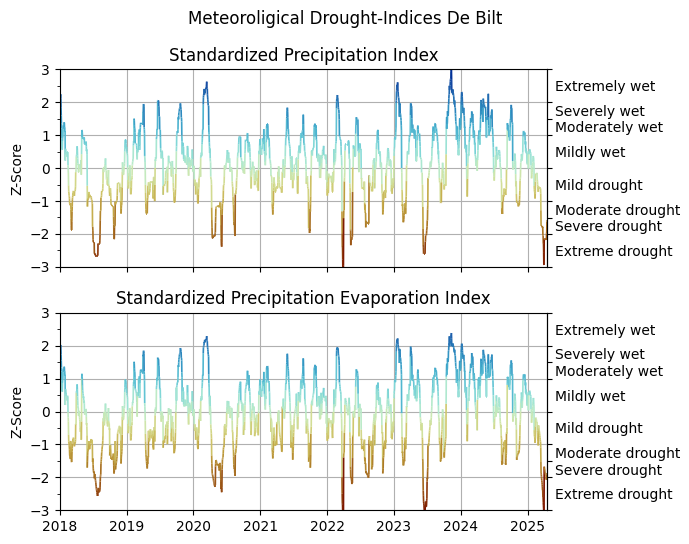

In [4]:
xlim = pd.to_datetime(["2018-01-01", yesterday])

fig, axs = plt.subplots(2, 1, figsize=(7.0, 5.5), sharex=True)
si.plot.si(spi1, ybound=3.1, ax=axs[0], background=False, cmap="roma")
si.plot.si(spei1, ybound=3.1, ax=axs[1], background=False, cmap="roma")
[(x.grid(), x.set_xlim(xlim), x.set_ylabel("Z-Score")) for x in axs]
axs[0].set_title("Standardized Precipitation Index")
axs[1].set_title("Standardized Precipitation Evaporation Index")
fig.suptitle("Meteoroligical Drought-Indices De Bilt")
fig.tight_layout()

## Create time series model and simulate head 

Fit report B32C0572_DE-BILT       Fit Statistics
nfev    93                     EVP         79.14
nobs    1187                   R2           0.79
noise   False                  RMSE         0.11
tmin    1970-07-01 00:00:00    AICc     -5278.14
tmax    2020-12-28 00:00:00    BIC      -5237.63
freq    D                      Obj          6.86
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (8 optimized)
                   optimal     initial   vary
recharge_A        0.437737    0.444131   True
recharge_a      171.554915   10.000000   True
recharge_srmax  101.115256  250.000000   True
recharge_lp       0.250000    0.250000  False
recharge_ks     802.472044  100.000000   True
recharge_gamma    1.903032    2.000000   True
recharge_kv       1.627433    1.000000   True
recharge_simax    2.000000    2.000000  False
recharge_gf       0.382370    1.000000   True
constant_d        0.980503    1.389835   True

Warnings! (1)
Response tma

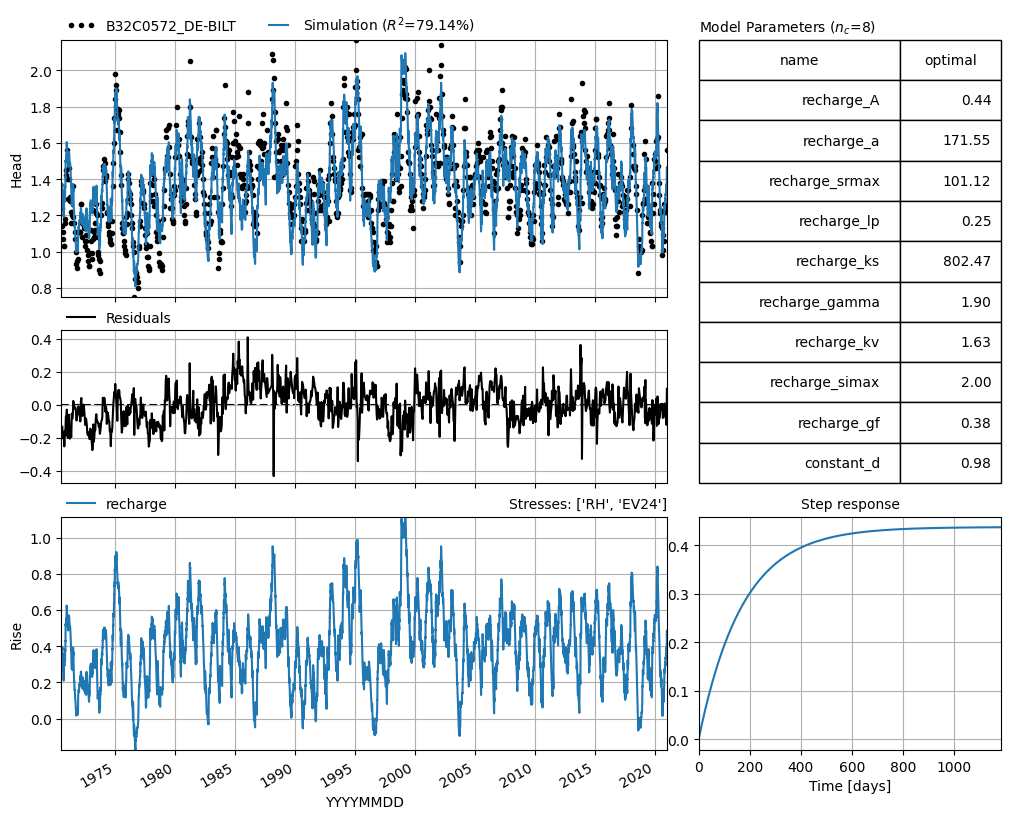

In [5]:
ml = ps.Model(head)
rm = ps.RechargeModel(
    prec, evap, ps.Exponential(), recharge=ps.rch.FlexModel(gw_uptake=True)
)
ml.add_stressmodel(rm)
ml.solve(tmin="1970-07-01", report=True)
_ = ml.plots.results(figsize=(10.0, 8.0))

## Calculate SGI based on time series model

In [6]:
gws = ml.simulate(tmin="1990-07-01", tmax=yesterday)
sgi = si.sgi(gws, fit_freq="MS")

## Compare three drought-indices (SPI, SPEI, SGI) in plot

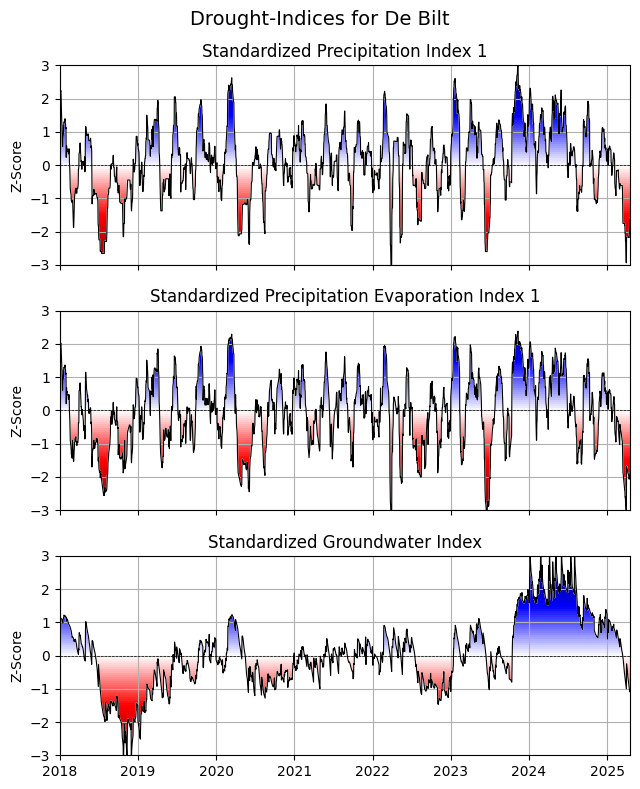

In [7]:
fig, axs = plt.subplot_mosaic(
    [["SPI"], ["SPEI"], ["SGI"]], figsize=(6.5, 8), sharex=True
)
si.plot.si(spi1, ybound=3.5, ax=axs["SPI"], add_category=False)
si.plot.si(spei1, ybound=3.5, ax=axs["SPEI"], add_category=False)
si.plot.si(sgi, ybound=3.5, ax=axs["SGI"], add_category=False)
[(axs[x].grid(), axs[x].set(xlim=xlim, ylabel="Z-Score")) for x in axs]
axs["SPI"].set_title("Standardized Precipitation Index 1")
axs["SPEI"].set_title("Standardized Precipitation Evaporation Index 1")
axs["SGI"].set_title("Standardized Groundwater Index")
fig.suptitle("Drought-Indices for De Bilt", fontsize=14)
fig.tight_layout()
# fig.savefig('Drought_Index_Bilt.png', dpi=600, bbox_inches='tight')

## Compare SPEI Kernel Density Estimate for one month

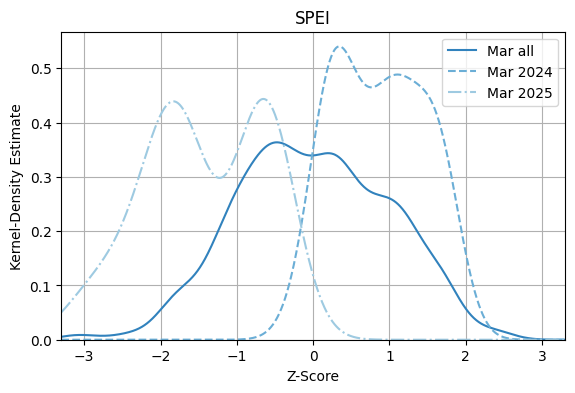

In [9]:
ax = si.plot.monthly_density(
    spi1, years=[today.year - 1, today.year], months=[today.month - 1]
)
ax.set_xlabel("Z-Score")
ax.set_title("SPEI");